In [ ]:
### Attention!
####  Because of the stored data in memory, it is nessecary to execute the
####   the entire project to see the results. For this purpose it is recommended
####   to do "Restart and run all".
### Attention!

In [ ]:
#############     This project belongs to Amir Gholizad     ###############
#######     M.Sc. Physics, Memorial University of Newfoundland      #######
#############     Designed for the CMSC 6920, Feb. 2023     ###############

**Adaptive Moving Mesh**

To effectively solve a BVP, the mesh points need to be focused near the steep
front and continuously adapted to keep up with the front's movement over time.
This kind of flexible mesh is called an *adaptive moving mesh*.

**Equidistribution**

To adjust the mesh in order to follow the front as it moves we can use a method based on the equidistribution principle, which aims to evenly distribute an error density function among all mesh elements. In one dimension, the equidistribution principle can uniquely determine a mesh for a given mesh density function, along with appropriate boundary conditions.

Equidistribution is a crucial concept in mesh adaptation. It involves creating a mesh that evenly distributes a given continuous function, represented by $M(x_i)$, over a bounded interval $[\alpha, \beta]$. The mesh is defined by a set of $n$ points on the interval, $x_{\alpha} = \alpha, x_0, ..., x_n, x_{\beta} = \beta$, and it is called an equidistributing mesh if the area under the function $M(x_i)$ is the same for every subinterval between the mesh points.
The mathematical form of this principle is
<center>$\int_{x_{\alpha}}^{x_{0}}M(x,u(x))dx=...=\int_{x_{n}}^{x_\beta}M(x,u(x))dx. \: \: (1)$  
</center>

The objective is to determine the optimum mesh for $u(x)$ using $M$ which is the *mesh density function*.The mesh density function is proportional to the density of the mesh when the equidistribution principle is satisfied. It must be non-negative, meaning that it can vanish locally, which may lead to non-unique equidistributing meshes. Therefore, the assumption is made that any mesh density function is strictly positive on the interval $[\alpha, \beta]$.

If we refer to the Fundamental Theorem of Calculus, for the entire interval of $[\alpha, \beta]$ we can say

<center>$ \frac{1}{n} \int_{x_{\alpha}}^{x_\beta}M(x,u(x))dx=\int_{x_{i}}^{x_{i+1}}M(x,u(x))dx. \: \: (2)$  
</center>

Also, if we define $\xi$ as $\xi = \frac{1}{n}$ and consequently for discrete space $\xi_i = \frac{i}{n}$ we will get

<center>$ \xi \int_{x_{\alpha}}^{x_\beta}M(x,u(x))dx=\int_{x_{i}}^{x_{i+1}}M(x,u(x))dx. \: \: (3)$  
</center>

By differentiating both sides of Eq.(2) with respect to $\xi$ we find

<center>$ \int_{x_{\alpha}}^{x_\beta}M(x,u(x))dx = M(x(\xi),u(x))\frac{dx}{d\xi} \: \: (4)$  
</center>

and second differentiation gives us

<center>$ \frac{d}{d\xi}(M(x(\xi),u(x))\frac{dx}{d\xi}) = 0. \: \: (5)$  
</center>

In this project our aim is to solve the Eq.(5) using a uniform grid $\xi$ as our initial guess, a pre-defined mesh density function $M$, the original function $u$ and find the final $x$ as our adaptive mesh for $u$. We will solve this equation using Newton's Method.

**Newton's Method**

Newton's Method is an iterative numerical method for finding the roots of a function. It starts with an initial guess for the root and then uses the derivative of the function to refine the estimate. The general idea is to iteratively improve an initial guess for the root by finding the zero of a linear approximation to the function at that point.

**The Algorithm**

Using a uniform grid like $x_i = \xi_i = \frac{i}{n}$ we can discretize the Eq.(5) and get to
<center>$ \frac{1}{2Δ\xi^2}((M_{i+1} + M_{i})(x_{i+1} - x_i) - (M_{i} + M_{i-1})(x_{i} - x_{i-1})) = 0. \: \: (6)$
</center>

We also asume that $x_{\alpha} = \alpha = 0$ and $x_{\beta} = \beta = 1$.

If we redefine the Eq.(6) as $G_i = 0$, the Newton's method will take the form
<center>
$ \Sigma_{j} J_{ij}.Δx_j = - G_i. \: \: (7)$
</center>

Here's how the algorithm works:

 -  We start with an initial guess $x = \xi = \frac{1}{n}$ for the root of the function $G(\xi)$.

 - We compute the Jacobian matrix of the function $G(\xi)$ at the guess $\xi$.

 - Using Eq.(7), we find the difference between $x$-intercept of the tangent line to the graph of $G(\xi)$ and $\xi$ and add it to $\xi$ to get the next guess for the root, $x$.

 - We repeat steps 2-4 with the new guess $x$ until the desired level of accuracy is achieved.


In [ ]:
# START #######################################################################
###############################################################################
# Adding required packages
import numpy as np
from scipy.sparse import diags
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Defining the required constants as global variables
n = 16      # Number of total nodes + 1
start = 0   # Start point of Xi
stop = 1    # Stop point of Xi
alpha = 0   # Initial value of X
beta = 1    # Boundary value of X
h = ( stop - start) / (n - 1)   # Spacing between the Xi nodes

In [ ]:
# Defining equidistributed initial grid, Xi
# This vector contains only the interior nodes starting from Xi(start + h)
#  to Xi(stop - h).
def Xi():
  return np.array( [i/(n-1) for i in range(1,n-1)] )   # Xi[i] = i/n-1

For the first part of the project we define $M$ as
$M(x_i) = 1 + Cx_{i}^2$

In [ ]:
# Defining the M(X,C) function whcih takes Xi(or X) and C(boundary layer),
#  and gives out M and dM/dx in every node
def M(X,C):
  m_ = 1 + C*(X**2)
  m_prime = C*2*X
  return m_, m_prime

We remember from Eq.(6) that
$ G_{i} = \frac{1}{2Δ\xi^2}((M_{i+1} + M_{i})(x_{i+1} - x_i) - (M_{i} + M_{i-1})(x_{i} - x_{i-1})) = 0$

In [ ]:
# Defining the G function which basically is the ODE of function M.
# We will use this function in Newton's Method which is: J * dX = -G
def G(x,C):

  # Updating M values
  m, mp = M(x,C)
  alpha_m, alpha_mp = M(alpha,C)
  beta_m, beta_mp = M(beta,C)

  # Initializing G vector
  gg = [0 for i in range(0, len(x))]
  N = len(x) - 1

  # Building G vector by adding its entries
  for i in range(1,N):
    gg[i] = ((m[i+1] + m[i])*(x[i+1] - x[i]) - (m[i] + m[i-1])*(x[i] - x[i-1]))

  # As the Xi(or X) and M vectors are only defined for internal nodes,
  #  we need to hard-code the G's first and last entries
  gg[0] = ((m[1] + m[0])*(x[1] - x[0]) - (m[0] + alpha_m)*(x[0] - alpha))
  gg[-1] = ((beta_m + m[-1])*(beta - x[-1]) - (m[-1] + m[-2])*(x[-1] - x[-2]))

  return np.array(gg)

When defining Jacobian, we should note that it is a diagonalized matrix with 3 diagonals which are

$J_{i, i-1} = M^{'}_{i-1} (x_{i-1} - x_{i}) + M_{i-1} + M_{i}$

$J_{i,i} = M^{'}_{i} (x_{i+1} - x_{i}) - (M_{i+1} + M_{i}) - M^{'}_{i}(x_{i}-x_{i-1}) - (M_{i} + M_{i-1})$

$J_{i,i+1} = M^{'}_{i+1} (x_{i+1} - x_{i}) + M_{i+1} + M_{i}$

In [ ]:
# Defining the Jacobian matrix.
# We will use this matrix in Newton's Method which is: J * dX = -G
def J(x,C):

   # Updating M values
   m, mp = M(x,C)
   alpha_m, alpha_mp = M(alpha,C)
   beta_m, beta_mp = M(beta,C)

   # Initializing three diagonals of Jacobian
   N = len(x) - 1

   # This is J[i][i-1] diagonal
   j_1 = [0 for i in range(0, len(x))]

   # This is J[i][i] diagonal (the main diagonal)
   j_2 = [0 for i in range(0, len(x))]

   # This is J[i][i+1] diagonal
   j_3 = [0 for i in range(0, len(x))]

   # Building Jacobian diagonals by adding their entries
   for i in range(1, N):
     # Covers the range from J[1][0] to J[N][N-1]
     j_1[i] = mp[i-1] * (x[i-1] - x[i]) + m[i-1] + m[i]

     # Covers the range from J[1][1] to J[N][N]
     j_2[i] = mp[i]*(x[i+1]-x[i])-m[i+1] - m[i]-mp[i]*(x[i]-x[i-1])-m[i]-m[i-1]

     # Covers the range from J[0][1] to J[N][N+1]
     j_3[i] = mp[i+1] * (x[i+1] - x[i]) + m[i+1] + m[i]


   # We need to hard-code the last entry of lower diagonal
   j_1[-1] = mp[-2] * (x[-2] - x[-1]) + m[N-1] + m[N]

   # We need to hard-code the first and last entries of main diagonal
   j_2[0] = mp[0]*(x[1]-x[0]) - m[1] - m[0] - mp[0]*(x[0]-alpha) - m[0]-alpha_m
   j_2[-1] = mp[-1]*(beta-x[-1])-beta_m-m[-1]-mp[-1]*(x[-1]-x[-2])-m[-1]-m[-2]

   # We need to hard-code the first entry of upper diagonal
   j_3[0] = mp[1] * (x[1] - x[0]) + m[1] + m[0]

   # Note that upper and lower diagonals should be smaller than main diagonal. #
    ###### So we drop the first entry of j_1 and the last entry of j_3. ######
   j = diags([j_1[1:], j_2, j_3[:-1]], [-1,0,1], shape= (N+1,N+1)).toarray()
   return j

In [ ]:
# Defining the iterative Newton's algorithm for solving ODEs.
def Newton(x,C):

  # Some (not necessary but useful!) simplifications!
  m, mp = M(x,C)
  alpha_m, alpha_mp = M(alpha,C)
  beta_m, beta_mp = M(beta,C)
  g = G(x,C)
  jacob = J(x,C)

  # DeltaX is the Correction which will be added to X in every iteration.
  DeltaX = np.ones(len(x))
  # The Counter is the number of iterations that it takes solve the equation.
  counter = 0

  while abs(np.average(DeltaX)) > 0.000001:
    # Solving J * DeltaX = -G
    DeltaX = np.linalg.solve(jacob,-g)
    # Updating X
    x = x + DeltaX
    # Updating M, G and J
    m, mp = M(x,C)
    alpha_m, alpha_mp = M(alpha,C)
    beta_m, beta_mp = M(beta,C)
    g = G(x,C)
    jacob = J(x,C)
    counter += 1
    continue

  return x , counter

In [ ]:
# This function creates X vs Xi and dX vs Xi graphs which are obtained from
#  newton's method. We can get graphs for different values of C(boundary layer).
def Grapher(C):

  # Getting an initial Xi
  xi = Xi()
  # Calling Newton function to solve the mesh ODE for given Xi and C
  answer, iterations = Newton(xi,C)

  # Redefining X and Xi so that they contain boundary values
  finalX = np.zeros(len(xi)+2).reshape(len(xi)+2)
  finalXi = np.zeros(len(xi)+2).reshape(len(xi)+2)
  finalX[0]= alpha
  finalX[-1] = beta
  finalXi[0]= start
  finalXi[-1] = stop
  finalX[1:len(xi)+1] = answer
  finalXi[1:len(xi)+1] = Xi()
  dx = finalX[1:] - finalX[:-1]
  # dx is the spacings in new X not the DeltaX(correction) from Newton's method.

  # Plotting!
  fig = plt.figure(figsize=(15, 6))
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122)


  ax1.scatter(finalXi,finalX,label='C = {}'.format(C),linewidth =0.25,c='black')
  ax1.set_xlabel('Xi')
  ax1.set_ylabel('X')
  ax1.set_title(f"X vs Xi - Number of iterations: {iterations}")
  ax1.legend();

  ax2.scatter(finalXi[1:],dx,label='C = {}'.format(C),linewidth =0.25,c='r')
  ax2.set_xlabel('Xi')
  ax2.set_ylabel('dX')
  ax2.set_title("dX vs Xi")
  ax2.legend();

In [ ]:
#We solve the mesh ODE for a uniform Xi and different values of C
# # Un-comment these lines below if you want to see the results!

# for c in [1,10,100]:
#   Grapher(c)

# plt.show()

Running the Newton's method for $n = 15$ for different values of $C = 1, 10, 100$ we get these graphs of $x$ vs $\xi$ and $Δx$ vs $\xi$:

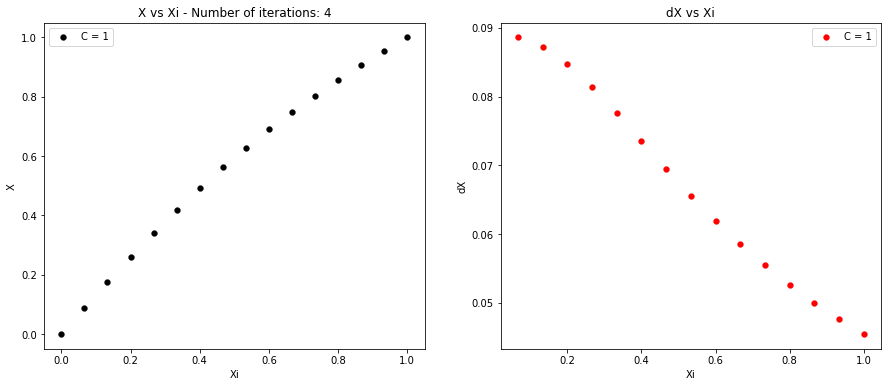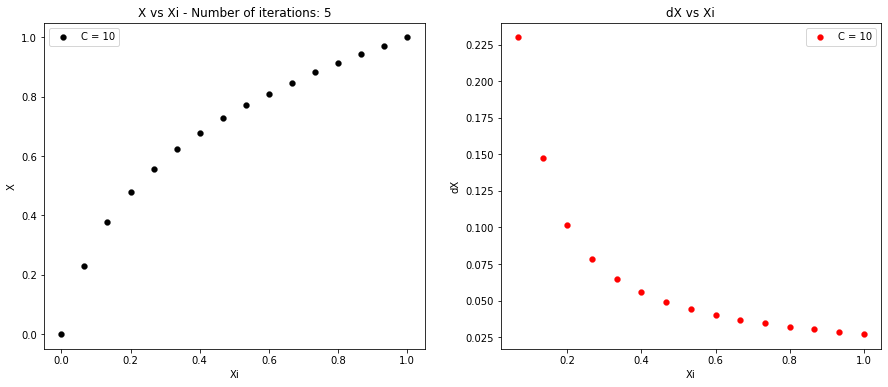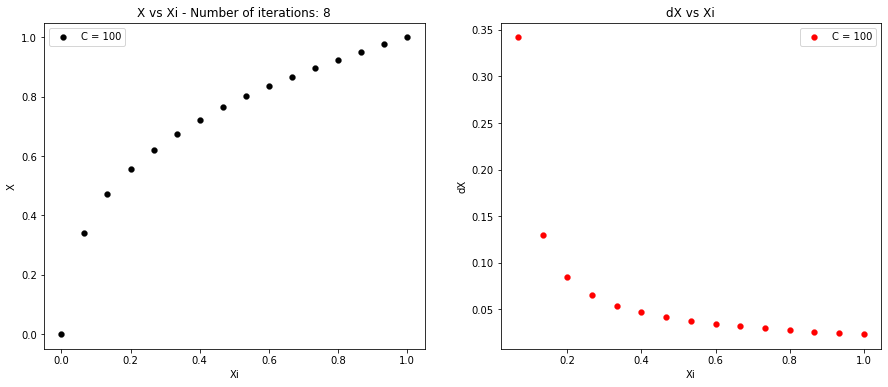

By observing these graphs we notice a few things.

For $Δx$ vs $\xi$ we see drastic changes for bigger values of $C$. These graphs show that for $C = 10, 100$ the distance between two adjacent points located at the end of the interval becomes much smaller, hence the density of the nodes gets much bigger.

Also, bigger values of $C$ results in more iterations through Newton's method to achieve the desirable accuracy.

For the last part of the project we choose the boundary layer problem with exact solution on this [webpsite](https://www.wolfram.com/language/12/asymptotics/solve-boundary-layer-odes-asymptoticdsolvevalue.html?product=mathematica).
The ODE of this function is
<center>$Lu^{''}(x) + 2u^{'}(x) + u(x) = 0$

$u(0) = 0, u(1) = \frac{1}{2}$
</center>
and the exact solution is
<center>
$u(x) = - \frac{ e^{\frac{1 + \sqrt{1-L}}{L}} (e^{x\frac{-1 - \sqrt{1-L}}{L}} - e^{x\frac{-1 + \sqrt{1-L}}{L}}) } {2(-1 + e^{\frac{2\sqrt{1-L}}{L}})}.$
</center>
Having the exact $u$ we obtain the optimum mesh for this function using new mesh density function $M(x) = \sqrt{1+u_x^2}$ where $u_x$ is the first derivative of $u$.

In [ ]:
# Defining U
def U(x, L):
  p1 = (1 + np.sqrt(1-L))/L
  p2 = (-1 - np.sqrt(1-L))/L
  p3 = (-1 + np.sqrt(1-L))/L
  p4 = (np.sqrt(1-L))/L

  u = -( np.exp(p1) * ( np.exp(x * p2) - np.exp(x * p3))) / (2*np.exp(2*p4) - 2)
  return u

# The ODE is: L * U" + 2 * U' + U = 0 with these boundary conditions:
alpha = 0
beta = 1

# Defining first and second derivatives of U(X)
def U_prime(x, L):

  u_x = 0.5*(-0.5 * np.exp((1-x)/2) + 2*(np.exp(1/2 - 2*x/L))/L )
  u_xx = 0.5*((0.25 * np.exp((1-x)/2) - 4*(np.exp(1/2 - 2*x/L))/(L**2)))
  return u_x , u_xx

# Redefining M
def NewM(X,L):
  u_x, u_xx = U_prime(X, L)

  m_ = np.sqrt(1 + u_x**2)
  m_prime = (u_x * u_xx)/np.sqrt(1 + u_x**2)

  return m_ , m_prime

# Updating M function
M = NewM

In [ ]:
# This function creates X vs Xi and dX vs Xi graphs which are obtained from
#  newton's method. We can get graphs for different values of C(boundary layer).
def Grapher2(xi, answer, iterations, L):

  # Redefining X and Xi so that they contain boundary values
  finalX = np.zeros(len(xi)+2).reshape(len(xi)+2)
  finalXi = np.zeros(len(xi)+2).reshape(len(xi)+2)
  finalX[0]= alpha
  finalX[-1] = beta
  finalXi[0]= start
  finalXi[-1] = stop
  finalX[1:len(xi)+1] = answer
  finalXi[1:len(xi)+1] = xi
  dx = finalX[1:] - finalX[:-1]
  # dx is the spacings in new X not the DeltaX(correction) from Newton's method.


  u = U(finalX, L)


  # Plotting!
  fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18, 6))


  ax1.scatter(finalXi,finalX,label='L = {}, n = {}'.format(L,n),linewidth=0.005,c='black')
  ax1.set_xlabel('xi')
  ax1.set_ylabel('x')
  ax1.set_title(f"x vs xi - Number of iterations: {iterations}")
  ax1.legend();

  ax2.scatter(finalX,u,label='L = {}, n = {}'.format(L,n),linewidth =0.005,c='r')
  ax2.set_xlabel('x')
  ax2.set_ylabel('u(x)')
  ax2.set_title("u vs x")
  ax2.legend();

  ax3.scatter(finalXi[1:],dx,label='L = {}, n = {}'.format(L,n),linewidth=0.005,c='black')
  ax3.set_xlabel('xi')
  ax3.set_ylabel('dx')
  ax3.set_title(f"dx vs xi - Number of iterations: {iterations}")
  ax3.legend();

In [ ]:
def iterator1(LList):

  # Getting an initial Xi
  xi = Xi()
  # Initiating a list for the number of iterations
  Iterations = []

  for L in LList:
    # Updating M
    M = NewM
    # Solving Newton's method
    answer, Iter = Newton(xi, L)
    # Updating Iterations list
    Iterations.append(Iter)
    Grapher2(xi, answer, Iter, L)

  return Iterations

Now we run the Newton's method for a fixed number of points $n = 15$ and different boundary layers of $ L = 0.001, 0.002, 0.005, 0.01, 0.02, 0.1, 0.5, 0.99$.

In [ ]:
# # Un-comment to see the results
# n = 21
# LList = [1/1000, 1/500, 1/200, 1/100, 1/50, 1/10, 1/2, 0.99]
# iterator1(LList)

For $ n = 15 $ and mentioned values of $L$ we get results below:

<center>
$n = 20$

|      L     | Iterations |
|------------|:------------|
|    0.001   |    NaN    |
|    0.002   |    NaN    |
|    0.005   |    30     |
|    0.01    |     21    |
|    0.02    |     17    |
|    0.1     |     10    |
|    0.5     |     4     |
|    0.99    |     3     |

Table (1)

</center>

As shown in the table above, with $n = 20$ for boundary layers $L < 0.005$ we encounter data overflow or divergance. We should note that for $L = 1.0$ the original function $u$ becomes mathematically undefined. The key feature we notice from Table (1) is that for a fixed number of nodes $n$ as we increase the value of boundary layer $L$, the number of iterations decreases.

Below are two sets of $x$ vs $\xi$, $u$ vs $x$ and $\Delta x$ vs $\xi$ plots for $L = 0.005, 0.99$
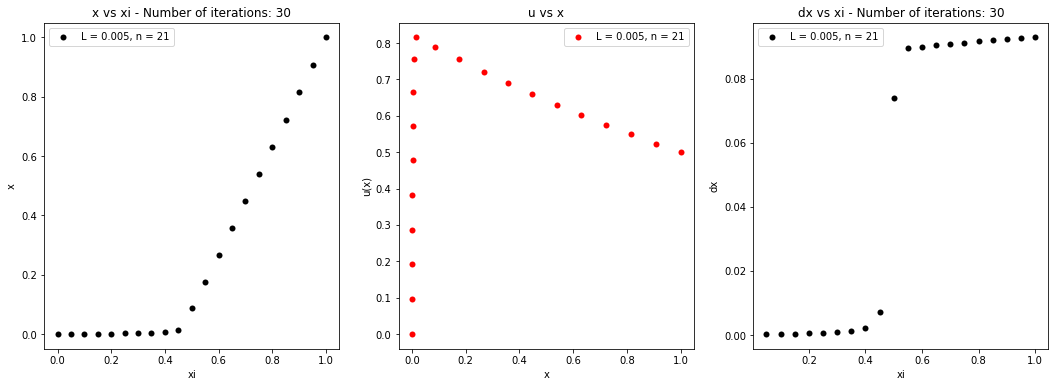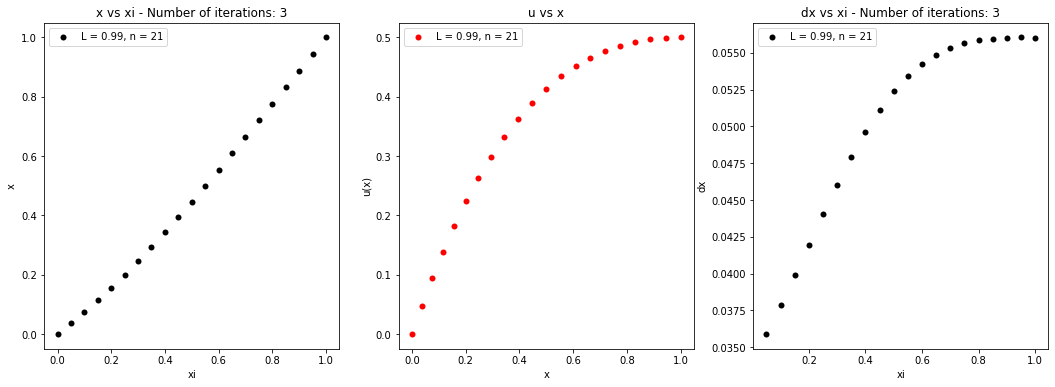


In [ ]:
# # Un-comment for the results
# nlist = [21,51,101,201, 501,1001,2001]
# LList = [0.005 ,0.01, 0.02, 0.1, 0.5, 0.99]
# Iterlist = []
# for N in nlist:
#   n = N
#   Iterlist.append(iterator1(LList))


This time, we study the results for different values of $L$ and $n$ to see the relationship between them.

<center>


|  n   |      L     | Iterations |
|------|------------|:-----------|
| 20   |    0.005   |    30     |
| 20   |    0.01    |    21     |
| 20   |    0.02    |    17     |
| 20   |    0.1     |    10     |
| 20   |    0.5     |    4     |
| 20   |    0.99    |    3     |
| 50   |    0.005   |    NaN     |
| 50   |    0.01    |    NaN     |
| 50   |    0.02    |    NaN     |
| 50   |    0.1     |    12     |
| 50   |    0.5     |    4     |
| 50   |    0.99    |    3     |
| 100   |    0.005  |    NaN     |
| 100   |    0.01   |    NaN     |
| 100   |    0.02   |    NaN     |
| 100   |    0.1    |    12     |
| 100   |    0.5    |    4     |
| 100   |    0.99   |    3     |
| 200   |    0.005  |    NaN     |
| 200   |    0.01   |    NaN     |
| 200   |    0.02   |    NaN     |
| 200   |    0.1    |    12     |
| 200   |    0.5    |    4     |
| 200   |    0.99   |    3     |
| 500   |    0.005  |    NaN     |
| 500   |    0.01   |    NaN     |
| 500   |    0.02   |    NaN     |
| 500   |    0.1    |    12     |
| 500   |    0.5    |    4     |
| 500   |    0.99   |    3     |
| 1000   |    0.005 |    NaN     |
| 1000   |    0.01  |    NaN     |
| 1000   |    0.02  |    NaN     |
| 1000   |    0.1   |    12     |
| 1000   |    0.5   |    4     |
| 1000   |    0.99  |    3     |
| 2000   |    0.005 |    NaN     |
| 2000   |    0.01  |    NaN     |
| 2000   |    0.02  |    NaN     |
| 2000   |    0.1   |    12     |
| 2000   |    0.5   |    4     |
| 2000   |    0.99  |   3     |

Table (2)


</center>


As shown in Table (2), for smaller boundary layers, as the number of nodes decreases, the Newton's method doesn't converge to an answer.
We also observe the same pattern which appeared in Table (1) for the fixed values of $n$. Another visible pattern is that for a fixed boundary layer $L$ as we add more nodes $n$ to the problem, it takes more iterations to complete the process.


In [ ]:
# Defining iterator2 which solves the Newton's method, gets an initial mesh,
#  and then uses that mesh to solve the problem
def iterator2(lList):

  # Getting an initial Xi
  xi = Xi()
  # Initiating a list for the number of iterations
  Iterations = []
  x, temp = Newton(xi, lList[-1])

  for L in lList[:-1]:
    # Updating M
    M = NewM
    # Solving Newton's method
    answer, Iter = Newton(x, L)
    # Updating Iterations list
    Iterations.append(Iter)
    Grapher2(xi, answer, Iter, L)

  return Iterations


For the last part of the project we solve the mesh for $L = 0.99$ and use the result as our initial guess ($\xi$) for solving the problem for lower values of $L$.

In [ ]:
# # Un-comment for seeing the results
# lList = [0.005 ,0.01, 0.02, 0.1, 0.5, 0.99]
# Nlist = [21,51,101,201,501,1001,2001]
# for N in Nlist:
#   n = N
#   iterator2(lList)

As shown in Table (3), we can see that except for one case ($L = 0.01 , n = 20$), the number of iterations for fixed $n$s has slightly decreased. For the comparison refer to Table (4) and Table (5).

<center>


|  n   |      L     | Iterations |
|------|------------|:-----------|
| 20   |    0.005   |    NaN     |
| 20   |    0.01    |    32     |
| 20   |    0.02    |    13     |
| 20   |    0.1     |    10     |
| 20   |    0.5     |    4     |
| 50   |    0.005   |    NaN     |
| 50   |    0.01    |    NaN     |
| 50   |    0.02    |    NaN     |
| 50   |    0.1     |    10     |
| 50   |    0.5     |    4     |
| 100   |    0.005  |    NaN     |
| 100   |    0.01   |    NaN     |
| 100   |    0.02   |    NaN     |
| 100   |    0.1    |    10     |
| 100   |    0.5    |    4     |
| 200   |    0.005  |    NaN     |
| 200   |    0.01   |    NaN     |
| 200   |    0.02   |    NaN     |
| 200   |    0.1    |    11     |
| 200   |    0.5    |    4     |
| 500   |    0.005  |    NaN     |
| 500   |    0.01   |    NaN     |
| 500   |    0.02   |    NaN     |
| 500   |    0.1    |    11     |
| 500   |    0.5    |    4     |
| 1000   |    0.005 |    NaN     |
| 1000   |    0.01  |    NaN     |
| 1000   |    0.02  |    NaN     |
| 1000   |    0.1   |    11     |
| 1000   |    0.5   |    4     |
| 2000   |    0.005 |    NaN     |
| 2000   |    0.01  |    NaN     |
| 2000   |    0.02  |    NaN     |
| 2000   |    0.1   |    11     |
| 2000   |    0.5   |    4     |


Table (3)

</center>

###With $\xi$ as initial guess

|  n   |      L     | Iterations |
|------|------------|:-----------|
| 20   |    0.02    |    17     |
| 500  |    0.1     |    12     |
| 2000 |    0.5     |    4     |

#####Table (4)



###With a mesh as initial guess

|  n   |      L     | Iterations |
|------|------------|:-----------|
| 20   |    0.02    |    13     |
| 500  |    0.1     |    11     |
| 2000 |    0.5     |    4     |

#####Table (5)
